## **Set up**

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, fisher_exact
from statsmodels.stats.multitest import multipletests
import glob
from pathlib import Path
import os
from numpy import dtype


In [34]:
import sys
from pathlib import Path

# Get the project root 
project_root = Path.cwd().parent

# Add project root to sys.path
sys.path.append(str(project_root))

## **1. Data Overview**

### 1.1. Load data and basic info

In [35]:
from src.utils import load_data

df = load_data("2015_raw.csv", subfolder="raw")

In [36]:
print(f"Shape: {df.shape}")
print("First few rows")
df.head()

Shape: (441456, 171)
First few rows


,GENHLTH,PHYSHLTH,MENTHLTH,POORHLTH,HLTHPLN1,PERSDOC2,MEDCOST,CHECKUP1,BPHIGH4,BPMEDS,...,_PAREC1,_PASTAE1,_LMTACT1,_LMTWRK1,_LMTSCL1,_RFSEAT2,_RFSEAT3,_FLSHOT6,_PNEUMO2,_AIDTST3
0,5.0,15.0,18,10.0,1,1,2.0,1.0,1.0,1.0,...,4,2,1.0,1.0,1.0,1,1,NaN,NaN,1.0
1,3.0,88.0,88,NaN,2,1,1.0,4.0,3.0,NaN,...,2,2,3.0,3.0,4.0,2,2,NaN,NaN,2.0
2,4.0,15.0,88,88.0,1,2,2.0,1.0,3.0,NaN,...,9,9,9.0,9.0,9.0,9,9,9.0,9.0,NaN
3,5.0,30.0,30,30.0,1,2,1.0,1.0,1.0,1.0,...,4,2,1.0,1.0,1.0,1,1,NaN,NaN,9.0
4,5.0,20.0,88,30.0,1,1,2.0,1.0,3.0,NaN,...,4,2,1.0,1.0,1.0,1,1,NaN,NaN,1.0


In [37]:
print("Columns:", df.columns.tolist())
print("\nInfo:")
print(df.info())

Columns: ['GENHLTH', 'PHYSHLTH', 'MENTHLTH', 'POORHLTH', 'HLTHPLN1', 'PERSDOC2', 'MEDCOST', 'CHECKUP1', 'BPHIGH4', 'BPMEDS', 'BLOODCHO', 'CHOLCHK', 'TOLDHI2', 'CVDINFR4', 'CVDCRHD4', 'CVDSTRK3', 'ASTHMA3', 'CHCSCNCR', 'CHCOCNCR', 'CHCCOPD1', 'HAVARTH3', 'ADDEPEV2', 'CHCKIDNY', 'DIABETE3', 'SEX', 'MARITAL', 'EDUCA', 'VETERAN3', 'EMPLOY1', 'CHILDREN', 'INCOME2', 'INTERNET', 'WEIGHT2', 'HEIGHT3', 'QLACTLM2', 'USEEQUIP', 'BLIND', 'DECIDE', 'DIFFWALK', 'DIFFDRES', 'DIFFALON', 'SMOKE100', 'SMOKDAY2', 'USENOW3', 'ALCDAY5', 'AVEDRNK2', 'DRNK3GE5', 'MAXDRNKS', 'FRUITJU1', 'FRUIT1', 'FVBEANS', 'FVGREEN', 'FVORANG', 'VEGETAB1', 'EXERANY2', 'EXRACT11', 'EXEROFT1', 'EXERHMM1', 'EXRACT21', 'EXEROFT2', 'EXERHMM2', 'STRENGTH', 'LMTJOIN3', 'ARTHDIS2', 'ARTHSOCL', 'JOINPAIN', 'SEATBELT', 'FLUSHOT6', 'FLSHTMY2', 'IMFVPLAC', 'PNEUVAC3', 'HIVTST6', 'PCDMDECN', 'TRNSGNDR', 'QSTVER', 'QSTLANG', 'EXACTOT1', 'EXACTOT2', '_CHISPNC', '_RFHLTH', '_HCVU651', '_RFHYPE5', '_CHOLCHK', '_RFCHOL', '_MICHD', '_LTASTH1',

In [38]:
from src.brfss_metadata import brfss_data_dict, describe_feature, search_description

print("Data Dict")
print(f"{'Column':<20} {'Dtype':<12} {'Description'}")
print("-" * 120)

for col, row in brfss_data_dict.iterrows():
    # These are the correct column names in your brfss_data_dict
    dtype    = row.get("Data Type", "NA")   # ← "DataType" (no space!)
    desc     = row["Description"]

    # Truncate long descriptions
    if len(desc) > 85:
        desc = desc[:82] + "..."

    # Beautiful aligned output
    print(f"{col:<20} {str(dtype):<12} {desc}")

Data Dict
Column               Dtype        Description
------------------------------------------------------------------------------------------------------------------------
GENHLTH              float64      General health
PHYSHLTH             float64      Days physical health not good
MENTHLTH             int64        Days mental health not good
POORHLTH             float64      Days poor health kept from usual activities
HLTHPLN1             int64        Have any health care coverage
PERSDOC2             int64        Have one or more personal doctors or  health care provider
MEDCOST              float64      Couldn’t see doctor because of cost (past 12 mo)
CHECKUP1             float64      Time since last routine checkup
BPHIGH4              float64      Ever told blood pressure high
BPMEDS               float64      Currently taking BP medicine
BLOODCHO             int64        Ever had blood cholesterol checked
CHOLCHK              float64      Time since last cholesterol check


### 1.2. Summary Statistics

In [39]:
def data_quality_report(df):
    report = {
        'Total Samples': len(df),
        'Total Features': len(df.columns),
        'Duplicate Rows': df.duplicated().sum(),
        'Memory Usage (MB)': df.memory_usage(deep=True).sum() / 1024**2
    }

    # Data types summary
    dtype_summary = df.dtypes.value_counts()

    return report, dtype_summary

quality_report, dtype_summary = data_quality_report(df)
print("Data Quality Report:")
for key, value in quality_report.items():
    print(f"{key}: {value}")

print("\nData Types Summary:")
print(dtype_summary)

Data Quality Report:
Total Samples: 441456
Total Features: 171
Duplicate Rows: 2
Memory Usage (MB): 631.8491468429565

Data Types Summary:
float64    111
int64       57
object       3
Name: count, dtype: int64


In [40]:
print(df.describe(include='all'))  

              GENHLTH       PHYSHLTH       MENTHLTH       POORHLTH  \
count   441454.000000  441455.000000  441456.000000  226964.000000   
unique            NaN            NaN            NaN            NaN   
top               NaN            NaN            NaN            NaN   
freq              NaN            NaN            NaN            NaN   
mean         2.578790      60.655113      64.679178      55.768959   
std          1.117585      37.055684      35.843085      38.070079   
min          1.000000       1.000000       1.000000       1.000000   
25%          2.000000      15.000000      28.000000      10.000000   
50%          2.000000      88.000000      88.000000      88.000000   
75%          3.000000      88.000000      88.000000      88.000000   
max          9.000000      99.000000      99.000000      99.000000   

             HLTHPLN1       PERSDOC2        MEDCOST       CHECKUP1  \
count   441456.000000  441456.000000  441455.000000  441455.000000   
unique            N

## **2. Missing Values & Constant Features**

### 2.1. Checking constant features

In [41]:
# Select columns with only one unique value
single_value_cols = df.columns[df.nunique() == 1]
print(f"Number of columns with a single unique value: {len(single_value_cols)}")
print(f"Columns with a single unique value: {single_value_cols}")


Number of columns with a single unique value: 0
Columns with a single unique value: Index([], dtype='object')


**Recommendation**

Drop all columns with a single unique value: `CTELENUM`, `COLGHOUS`, `STATERES`, `CTELNUM1`, `CCLGHOUS`

### 2.2. Checking missing values

In [42]:
# Columns with missing data
missing_cols = df.columns[df.isnull().any()]

# Count missing values per column
missing_counts = df[missing_cols].isnull().sum()

# Percentage missing per column
missing_percent = (df[missing_cols].isnull().mean() * 100)

high_missing = missing_percent[missing_percent > 50].sort_values(ascending=False)  # more than 50% missing
medium_missing = missing_percent[(missing_percent <= 50) & (missing_percent > 10)].sort_values(ascending=False)
low_missing = missing_percent[missing_percent <= 10].sort_values(ascending=False)

print("High missing (>50%)", high_missing.shape[0])
print("Medium missing (10-50%)", medium_missing.shape[0])
print("Low missing (<=10%)", low_missing.shape[0])


High missing (>50%) 18
Medium missing (10-50%) 24
Low missing (<=10%) 58


In [43]:
def print_missing_with_desc(title: str, series):
    print(f"\n{title} ({len(series)} columns)")
    print("-" * 110)
    for col in series.index:
        miss_pct = missing_percent[col]
        if col in brfss_data_dict.index:
            desc = brfss_data_dict.loc[col, "Description"]
            if len(desc) > 80:
                desc = desc[:77] + "..."
        else:
            desc = "(no description in metadata)"
        print(f"{col:<16} │ {miss_pct:>6.1f}% │ {desc}")

print_missing_with_desc("High missing (>50%)",     high_missing)
print_missing_with_desc("Medium missing (10–50%)", medium_missing)
print_missing_with_desc("Low missing (≤10%)",      low_missing)


High missing (>50%) (18 columns)
--------------------------------------------------------------------------------------------------------------
JOINPAIN         │   69.7% │ Average joint pain past 30 days (0-10)
ARTHSOCL         │   69.1% │ Arthritis interferes with social activities
ARTHDIS2         │   69.1% │ Arthritis affects work
LMTJOIN3         │   69.0% │ Limited due to joint symptoms (arthritis)
_PNEUMO2         │   64.2% │ Pneumonia vaccine ever age 65+ (calc)
_FLSHOT6         │   64.2% │ Flu shot past year age 65+ (calc)
TRNSGNDR         │   62.2% │ Transgender identity
BPMEDS           │   59.6% │ Currently taking BP medicine
SMOKDAY2         │   58.3% │ Current smoking frequency
FLSHTMY2         │   56.9% │ Month/year of last flu shot
IMFVPLAC         │   56.7% │ Place of last flu vaccine
PADUR2_          │   56.4% │ Duration secondary (min)
PAFREQ2_         │   55.9% │ Frequency secondary (calc)
EXERHMM2         │   55.4% │ Duration of secondary activity
EXEROFT2        

**Missing Data Handling Recommendation**

| Missing Level       | % Missing     | # Columns |Recommended Action                                 |
|---------------------|---------------|----------------------------------------------------|-----------------------------------------------------|
| High            | > 50%         | 150        | Consider Dropping (unless domain-critical)                   |
| Medium          | 10% – 50%     | 35        | Conditional imputation or drop                      |
| Low             | ≤ 10%         | 59       | Impute (simple or advanced)                         |

**Missingness Mechanism Guide**

| Type  | Meaning                                 |  Recommended Handling                                      |
|-------|-----------------------------------------|------------------------------------------------------------|
| MCAR  | Missing completely at random            | Random survey skip                                     | Simple imputation (mean/median/mode) or drop               |
| MAR   | Missing at random (depends on observed) | Conditional imputation (by group) or MICE              |
| MNAR  | Missing not at random (informative)     |  Create missing indicator + impute (median/'Missing')   |

**Rationale**:  
- 48 columns have >50% missing → mostly “specify other” text fields and child-module questions  
- Most high-missing variables are structurally absent (MAR), not random  
- Keeping them would introduce noise; dropping them is standard practice in BRFSS literature

**Next steps**:  
```python
cols_to_drop = high_missing.index.tolist() + child_module_cols
df_clean = df.drop(columns=cols_to_drop)

## **3. Target Variable Exploration**

In [44]:
target = "_MICHD"

### 3.1. Distribution of targets

In [45]:
df[target].value_counts()

_MICHD
2.0    398881
1.0     38633
Name: count, dtype: int64

Number of people with cardiovascular disease: 38,633
Number of people without cardiovascular disease: 398,881
Total respondents: 441,456
Prevalence of reported CHD/MI: 8.75%


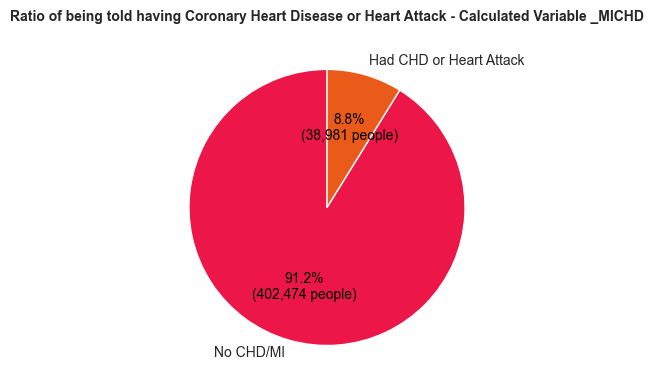

In [46]:
n_total = len(df[target])

# Counts
count_yes = (df[target] == 1).sum()
count_no  = (df[target] == 2).sum()
prevalence = count_yes / n_total * 100

print(f"Number of people with cardiovascular disease: {count_yes:,}")
print(f"Number of people without cardiovascular disease: {count_no:,}")
print(f"Total respondents: {n_total:,}")
print(f"Prevalence of reported CHD/MI: {prevalence:.2f}%")


plt.figure(figsize=(8, 4))
sns.set_style("white")

colors = ["#EC1648", "#EA5B19"] 

wedges, texts, autotexts = plt.pie(
    [count_no, count_yes],
    labels=['No CHD/MI', 'Had CHD or Heart Attack'],
    autopct=lambda pct: f'{pct:.1f}%\n({int(pct/100 * n_total):,} people)',
    startangle=90,
    colors=colors,
    textprops={'fontsize': 10},
    wedgeprops={'edgecolor': 'white', 'linewidth': 1}
)

# Make percentage bold and dark
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontsize(10)

plt.title("Ratio of being told having Coronary Heart Disease or Heart Attack - Calculated Variable _MICHD", 
          fontsize=10, fontweight='bold', pad=10)

plt.tight_layout()
plt.show()

### 3.2. Imbalance Interpretation

- The dataset shows a severe class imbalance, with only about ~8.8% of respondents reporting a Coronary Heart Disease or Heart Attack (`_MICHD = Yes`).
- This imbalance increases the risk that machine learning models will become biased toward predicting the majority class ("No").  
- In this context, accuracy is not a reliable metric, since even a naive model that always predicts "No" would achieve about ~91.2% accuracy.  

### 3.3. Implication for Modeling

**Next Steps:**
1. Resampling strategies:
   - Oversample minority class (e.g., SMOTE)
   - Undersample majority class
   - Use class weighting (`class_weight='balanced'` in sklearn)
2. Stratified splitting: Use stratified train/test splits to preserve the original imbalance ratio across datasets
3. Feature analysis: Compare distributions of key features between "Yes" and "No" groups to identify discriminative patterns
4. Threshold tuning: Optimize classification threshold (default 0.5) using validation metrics

**Medical Context Note**: In heart attack prediction, *false negatives* (missing actual cases) are particularly dangerous. Prioritize high recall while monitoring precision to avoid excessive false alarms. Using `SMOTE` or `class weighting` is recommended to address this imbalance.


## **4. Univariate Analysis**

cái này là drop trước mấy cái 100% không quan trọng: như ngày tháng năm khảo sát, mấy cái biến bài tập thể dục mà lát sau đưa vào biến khác rồi, và nhà có bao nhiêu trẻ em, tình trạng mang thai (tao nghĩ không quan trọng nhưng nếu m thấy k hợp lý thì xóa), và tất nhiên mấy biến missing 100% và mấy biến chỉ có 1 giá trị

### Drops obvious unimportant features before univariate analysis

In [47]:
# Intial dropping
to_drop = [
    # Survey administration & design 
    'QSTVER','QSTLANG',
    
    # Open-ended / raw activity (already summarized in clean vars) 
    'EXRACT11','EXRACT21','EXEROFT1','EXEROFT2','EXERHMM1','EXERHMM2'    
]
extreme_missing = list(missing_percent[missing_percent == 100].sort_values(ascending=False).index) 
df_clean = df.drop(columns=to_drop + extreme_missing + list(single_value_cols))
df_clean.shape

(441456, 163)

In [48]:
num_cols = df_clean.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = df_clean.select_dtypes(include=['object','category','bool']).columns.tolist()

num_cols = [c for c in num_cols if c != target]  
print(f'Number of categorical features: {len(cat_cols)}')
print(f'Number of numerical features: {len(num_cols)}')

Number of categorical features: 3
Number of numerical features: 159


### 4.1. Encode categorical features

In [49]:
for col in cat_cols:
    print(df[col].value_counts())

PCDMDECN
b''        441201
b'1'          208
b'2'           21
b'12'           7
b'4'            5
b'9'            4
b'7'            3
b'3'            2
b'21'           2
b'13'           1
b'1234'         1
b'14'           1
Name: count, dtype: int64
EXACTOT1
b''                    428378
b'cardio'                 410
b'treadmill'              380
b'TREADMILL'              318
b'physical therapy'       226
                        ...  
b'aerobicos'                1
b'quica'                    1
b'balonmano'                1
b'artes marciales'          1
b'martal arts'              1
Name: count, Length: 5642, dtype: int64
EXACTOT2
b''              424831
b'stretching'       349
b'STRETCHING'       267
b'treadmill'        240
b'cardio'           213
                  ...  
b'roll march'         1
b'barbel'             1
b'VOLLEYBALL'         1
b'STREACHING'         1
b'airsoft'            1
Name: count, Length: 7623, dtype: int64


đơn giản là vẽ bar chart của 3 biến categorical, và chọn 10 values trong từng features mà có tần suất nhiều nhất tại mấy feature này chia nhiều mục

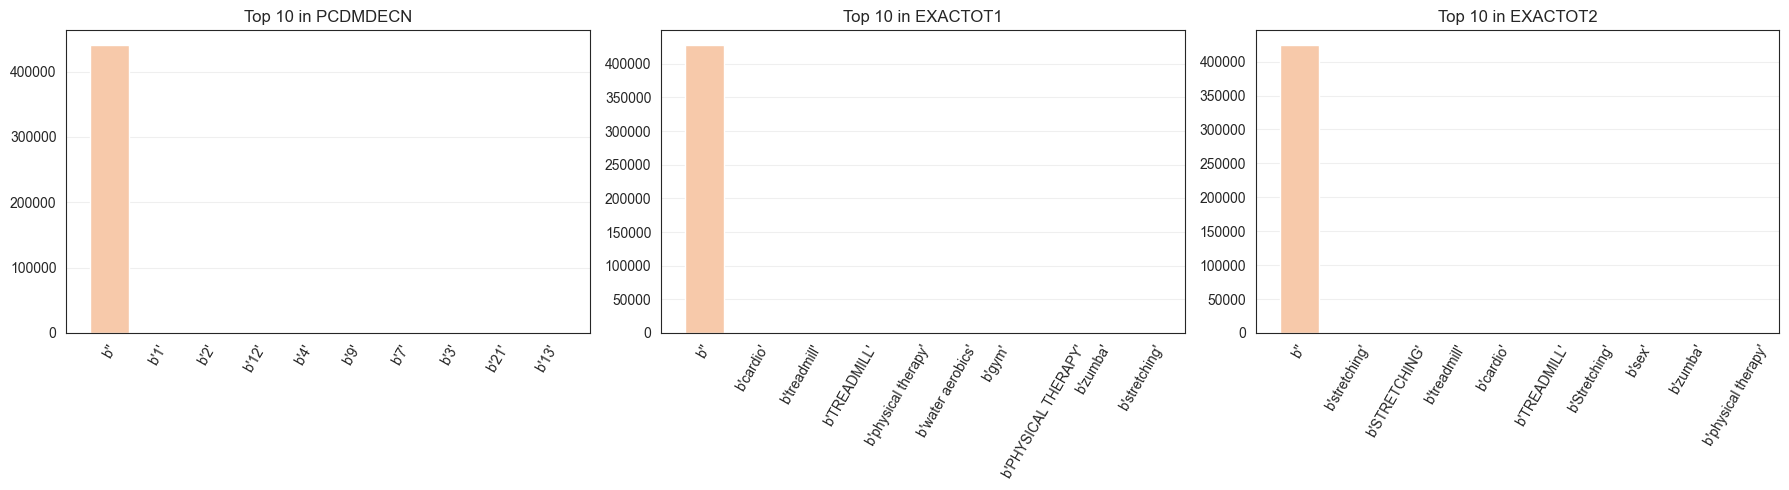

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

top_n =  10   # top values inside each feature
n_cols = len(cat_cols)   # one subplot per feature
fig, axes = plt.subplots(1, n_cols, figsize=(6*n_cols, 5))

# If only one feature, axes won't be iterable
if n_cols == 1:
    axes = [axes]

for ax, col in zip(axes, cat_cols):
    # Get top N frequent values for this feature
    top_vals = df_clean[col].value_counts().head(top_n)

    # Colors
    colors = sns.color_palette('rocket_r', n_colors=len(top_vals))

    # Bar plot
    ax.bar(top_vals.index, top_vals.values, color=colors)
    ax.set_title(f"Top {top_n} in {col}", fontsize=12)
    ax.tick_params(axis='x', rotation=60)
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


The columns `EXACTOT1` and `EXACTOT2` should be removed.

These are free-text fields containing detailed descriptions and are not case-sensitive.

They have already been replaced by clearer and significantly more robust fields such as PhysicalActivities.

### 4.2. Numerical Features

Since it’s not feasible to manually plot all 171 features,they have been filtered down.

Pearson correlation works well for linear relationships, but it only captures linear patterns and will miss nonlinear ones.
Mutual Information captures both linear and nonlinear relationships, but it is sensitive to noise and high cardinality.
If only one of the two metrics is used, it becomes easy to either miss or mistakenly select truly important features.

Therefore:

Compute correlation to represent strong linear relationships.

Compute mutual information to represent more general (including nonlinear) relationships.

Combine the two by averaging their scores → features that score highly on both metrics are very likely to be important.
Features that only one metric favors will have their combined score reduced → lowering false positives.

Selecting the top 30 features provides a manageable number for detailed heatmaps, pairplots, and distribution plots without becoming overwhelming.

vì không thể ngồi plot hết 171 feature nên t quyết định lọc bớt feature

Pearson correlation ổn với quan hệ tuyến tính cơ mà chỉ bắt được quan hệ tuyến tính, bỏ sót quan hệ phi tuyến
Mutual Information bắt được cả tuyến tính lẫn phi tuyến, nhạy cảm với nhiễu, cardinality cao.
Nếu chỉ dùng 1 trong 2, dễ bỏ sót hoặc chọn nhầm các feature thực sự mạnh.

Nên là: Tính correlation đại diện cho mối quan hệ tuyến tính mạnh.
Tính mutual information đại diện cho mối quan hệ tổng quát (kể cả phi tuyến)
Gộp lại, lấy trung bình điểm -> feature nào cả hai metric đều đánh giá cao thì chắc chắn quan trọng
. feature nào chỉ một trong hai thích thì sẽ bị kéo điểm xuống -> giảm false positive
Top 30 là con số vừa đủ để vẽ heatmap, pairplot, distribution plot chi tiết mà không bị quá tải.

In [ ]:
from sklearn.feature_selection import mutual_info_classif
import pandas as pd
import numpy as np

# Create a clean version for MI calculation (no NaN in features or target)
df_mi = df_clean[num_cols + [target]].copy()

# Fill numeric features with median
df_mi[num_cols] = df_mi[num_cols].fillna(df_mi[num_cols].median())

# If target still has NaN after filling features, you must handle it:
if df_mi[target].isna().any():
    # Either drop rows with missing target
    df_mi = df_mi.dropna(subset=[target])
    print(f"Dropped {df_clean[target].isna().sum()} rows with missing target.")
    
    # Or fill target (only if it makes sense — usually NOT recommended for target!)
    # df_mi[target] = df_mi[target].fillna(df_mi[target].mode()[0])

# Now both X and y are clean
X_mi = df_mi[num_cols]
y_mi = df_mi[target]

# Correlation (absolute) with target — using original df_clean is fine
# (since .corrwith handles NaN by skipping)
corr_scores = df_clean[num_cols].corrwith(df_clean[target]).abs()

# Mutual Information
mi_scores = mutual_info_classif(X_mi, y_mi, random_state=42)  # add random_state for reproducibility
mi_scores = pd.Series(mi_scores, index=num_cols, name='mi')

# Combine
feature_rank = pd.concat([corr_scores.rename('corr'), mi_scores], axis=1)

# Handle possible NaN in correlation (if a column has no variation or all NaN)
feature_rank['corr'] = feature_rank['corr'].fillna(0)

# Average score (you can also use rank-based averaging for more robustness)
feature_rank['score'] = feature_rank.mean(axis=1)

# Select top 20
top_num = feature_rank.sort_values(by='score', ascending=False).head(20).index.tolist()

print("Top 30 numeric features for univariate EDA:")
print(top_num)
print("\nDetailed ranking:")
print(feature_rank.sort_values(by='score', ascending=False).head(20))

Dropped 3942 rows with missing target.
Top 40 numeric features for univariate EDA:
['CVDINFR4', 'CVDCRHD4', 'GENHLTH', 'BPHIGH4', 'DIABETE3', '_AGE80', '_AGEG5YR', '_DRDXAR1', 'EMPLOY1', '_HCVU651', '_AGE_G', 'USEEQUIP', '_RFHLTH', '_AGE65YR', '_RFHYPE5', 'DIFFWALK', 'CHILDREN', 'CHCCOPD1', 'CVDSTRK3', 'QLACTLM2']

Detailed ranking:
              corr        mi     score
CVDINFR4  0.628853  0.237681  0.433267
CVDCRHD4  0.383577  0.263798  0.323687
GENHLTH   0.244916  0.049029  0.146973
BPHIGH4   0.205225  0.069947  0.137586
DIABETE3  0.161836  0.107584  0.134710
_AGE80    0.225152  0.031786  0.128469
_AGEG5YR  0.219578  0.037159  0.128368
_DRDXAR1  0.169966  0.086203  0.128085
EMPLOY1   0.207850  0.046207  0.127029
_HCVU651  0.196766  0.055430  0.126098
_AGE_G    0.207703  0.044457  0.126080
USEEQUIP  0.135539  0.106172  0.120856
_RFHLTH   0.172016  0.064680  0.118348
_AGE65YR  0.185658  0.048174  0.116916
_RFHYPE5  0.170942  0.059166  0.115054
DIFFWALK  0.134928  0.072816  0.103872
CH

In [59]:
# Select top 30
top_num = feature_rank.sort_values(by='score', ascending=False).head(30).index.tolist()

print("Top 30 numeric features for univariate EDA:")
print(top_num)
print("\nDetailed ranking:")
print(feature_rank.sort_values(by='score', ascending=False).head(30))

Top 30 numeric features for univariate EDA:
['CVDINFR4', 'CVDCRHD4', 'GENHLTH', 'BPHIGH4', 'DIABETE3', '_AGE80', '_AGEG5YR', '_DRDXAR1', 'EMPLOY1', '_HCVU651', '_AGE_G', 'USEEQUIP', '_RFHLTH', '_AGE65YR', '_RFHYPE5', 'DIFFWALK', 'CHILDREN', 'CHCCOPD1', 'CVDSTRK3', 'QLACTLM2', 'VETERAN3', 'HAVARTH3', 'TOLDHI2', 'ARTHSOCL', 'DIFFALON', 'ACTIN11_', '_RFCHOL', 'PHYSHLTH', 'INTERNET', 'PNEUVAC3']

Detailed ranking:
              corr        mi     score
CVDINFR4  0.628853  0.237681  0.433267
CVDCRHD4  0.383577  0.263798  0.323687
GENHLTH   0.244916  0.049029  0.146973
BPHIGH4   0.205225  0.069947  0.137586
DIABETE3  0.161836  0.107584  0.134710
_AGE80    0.225152  0.031786  0.128469
_AGEG5YR  0.219578  0.037159  0.128368
_DRDXAR1  0.169966  0.086203  0.128085
EMPLOY1   0.207850  0.046207  0.127029
_HCVU651  0.196766  0.055430  0.126098
_AGE_G    0.207703  0.044457  0.126080
USEEQUIP  0.135539  0.106172  0.120856
_RFHLTH   0.172016  0.064680  0.118348
_AGE65YR  0.185658  0.048174  0.116916
_

xem lại cái tổng quan missing , unique, rồi min, max từng cái

In [60]:
num_summary = df_clean[top_num].describe().T
num_summary['missing_%'] = df_clean[top_num].isna().mean() * 100
num_summary['skewness'] = df_clean[top_num].skew()
num_summary['kurtosis'] = df_clean[top_num].kurt()
num_summary['unique'] = df_clean[top_num].nunique()
num_summary = num_summary[['count', 'unique', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'skewness', 'kurtosis', 'missing_%']]
num_summary.round(2)

,count,unique,mean,std,min,25%,50%,75%,max,skewness,kurtosis,missing_%
CVDINFR4,441456.0,4,1.97,0.44,1.0,2.0,2.0,2.0,9.0,8.07,105.84,0.00
CVDCRHD4,441455.0,4,1.99,0.53,1.0,2.0,2.0,2.0,9.0,7.51,75.85,0.00
GENHLTH,441454.0,7,2.58,1.12,1.0,2.0,2.0,3.0,9.0,0.60,0.77,0.00
BPHIGH4,441455.0,6,2.21,1.04,1.0,1.0,3.0,3.0,9.0,0.18,0.99,0.00
DIABETE3,441449.0,6,2.76,0.72,1.0,3.0,3.0,3.0,9.0,-1.20,5.72,0.00
_AGE80,441456.0,63,55.41,17.04,18.0,43.0,58.0,69.0,80.0,-0.41,-0.80,0.00
_AGEG5YR,441456.0,14,7.80,3.50,1.0,5.0,8.0,10.0,14.0,-0.31,-0.84,0.00
_DRDXAR1,438657.0,2,1.66,0.47,1.0,1.0,2.0,2.0,2.0,-0.69,-1.53,0.63
EMPLOY1,441456.0,9,3.94,2.87,1.0,1.0,3.0,7.0,9.0,0.16,-1.77,0.00
_HCVU651,441456.0,3,3.95,3.80,1.0,1.0,1.0,9.0,9.0,0.57,-1.66,0.00


plot mấy feature mới ra

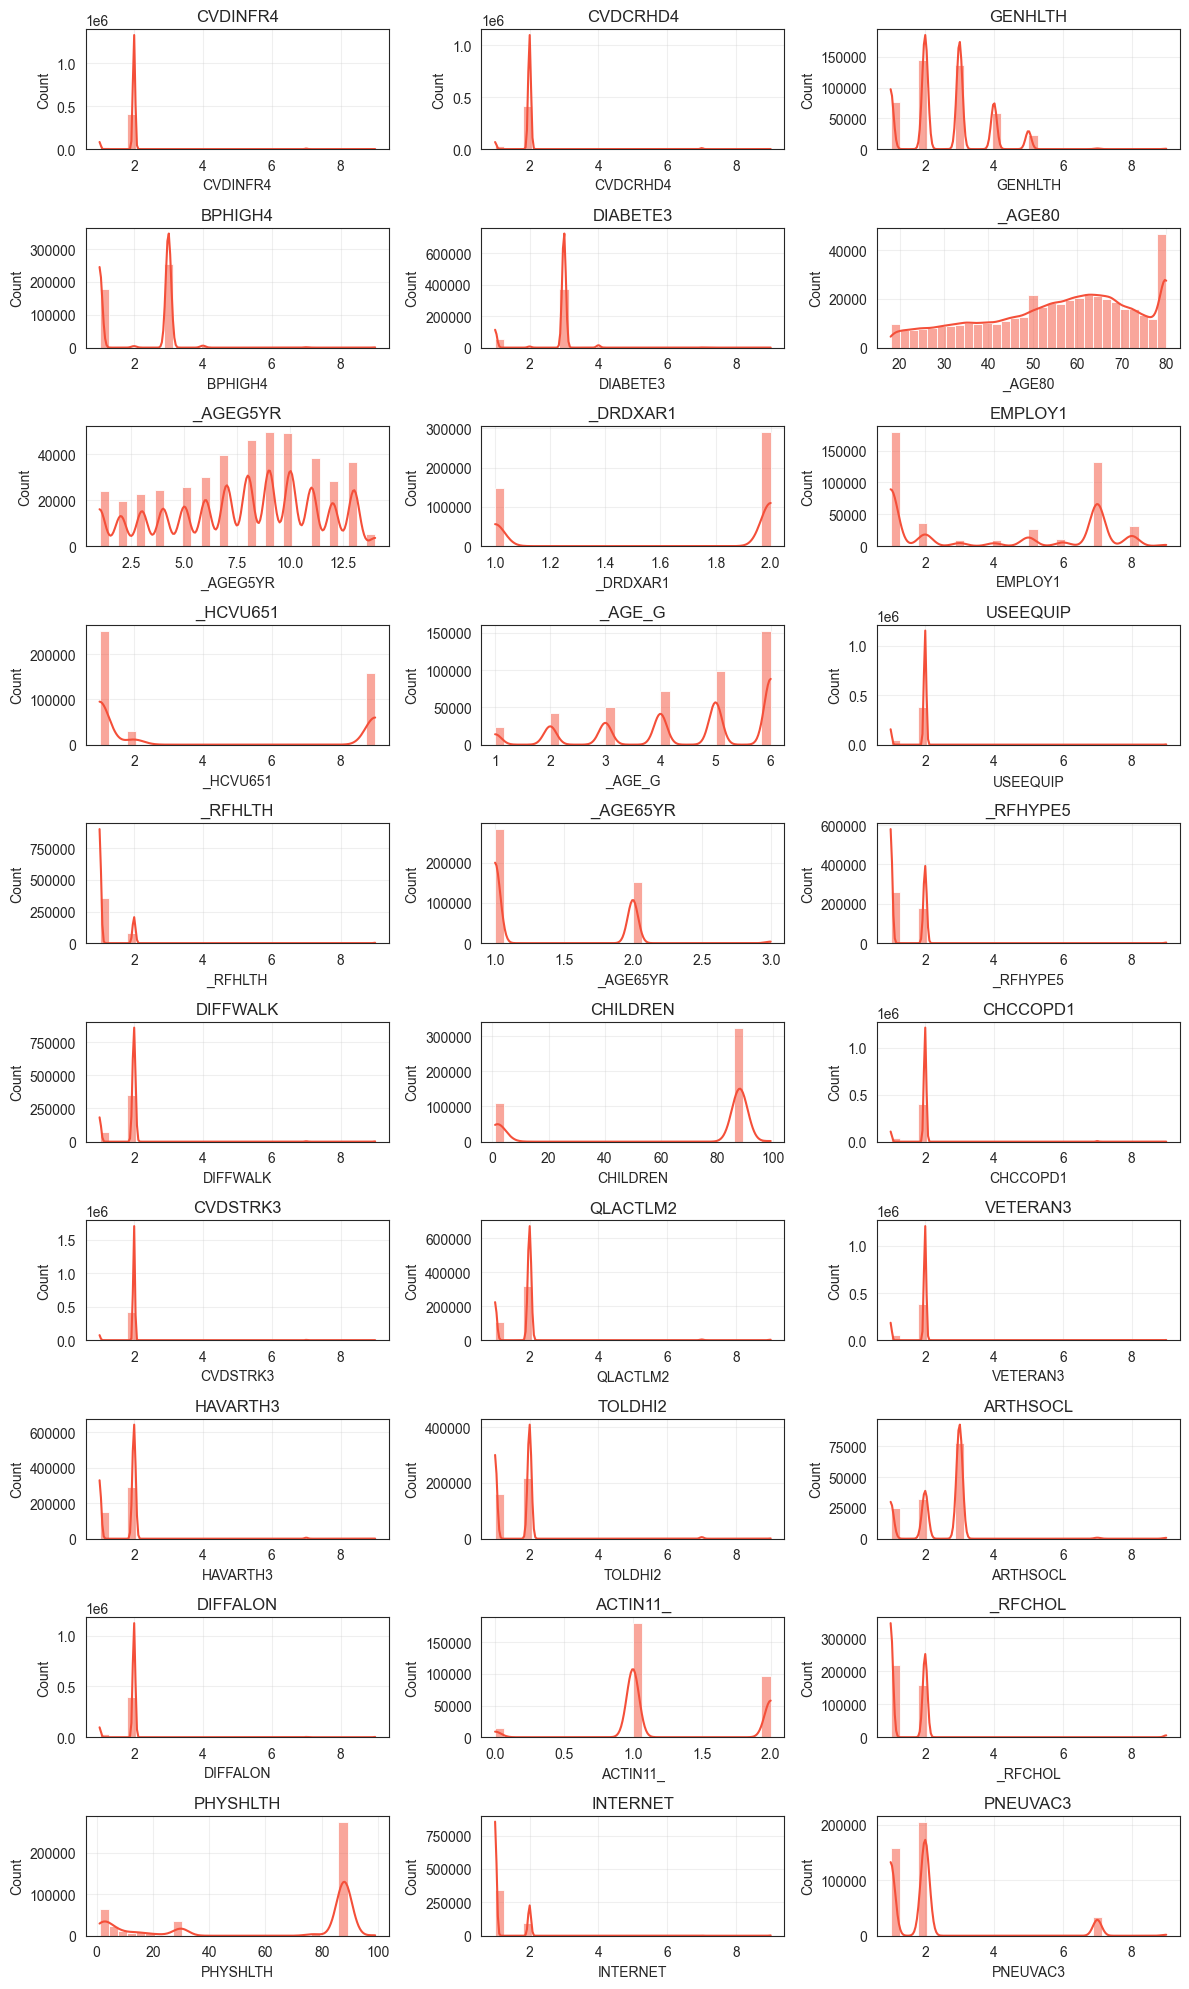

In [62]:
n = len(top_num)
rows = (n + 1) // 3
fig, axes = plt.subplots(rows, 3, figsize=(12, rows * 2))
axes = axes.flatten()
red_color = sns.color_palette("Reds", 6)[3]  # màu đỏ trung tính

for i, col in enumerate(top_num):
    sns.histplot(df_clean[col].dropna(), bins=30, kde=True, color=red_color, ax=axes[i])
    axes[i].set_title(col)
    axes[i].grid(alpha=0.3)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Một số feature có chỉ có vài giá trị rời rạc, thay vì phân phối liên tục mượt mà. 

-> dấu hiệu của biến categorical bị nhầm thành numerical.

vậy nên ở dưới t quyết định kiểm tra bằng cách xem mấy features mà chỉ có < 20 giá trị unique thì có khả năng cao là categorical đặc biệt với nhiều quan sát như thế

Some features contain only a few discrete values instead of a smooth continuous distribution.

This suggests that certain categorical variables were mistakenly treated as numerical.

Therefore, as shown below, features which have fewer than 20 unique values are checked, as these are highly likely to be categorical — especially given the large number of observations.

In [64]:
# Checking unique values
for col in df[num_cols].columns:
    n_unique = df[col].nunique()
    if n_unique < 20: 
        print(f"{col}: {n_unique} unique values -> potential categorical!")

GENHLTH: 7 unique values -> potential categorical!
HLTHPLN1: 4 unique values -> potential categorical!
PERSDOC2: 5 unique values -> potential categorical!
MEDCOST: 4 unique values -> potential categorical!
CHECKUP1: 7 unique values -> potential categorical!
BPHIGH4: 6 unique values -> potential categorical!
BPMEDS: 4 unique values -> potential categorical!
BLOODCHO: 4 unique values -> potential categorical!
CHOLCHK: 6 unique values -> potential categorical!
TOLDHI2: 4 unique values -> potential categorical!
CVDINFR4: 4 unique values -> potential categorical!
CVDCRHD4: 4 unique values -> potential categorical!
CVDSTRK3: 4 unique values -> potential categorical!
ASTHMA3: 4 unique values -> potential categorical!
CHCSCNCR: 4 unique values -> potential categorical!
CHCOCNCR: 4 unique values -> potential categorical!
CHCCOPD1: 4 unique values -> potential categorical!
HAVARTH3: 4 unique values -> potential categorical!
ADDEPEV2: 4 unique values -> potential categorical!
CHCKIDNY: 4 unique v

các feature này nên được kiểm tra lại để tránh gán số trực tiếp cho những categorical không có thứ bậc

These features should be reviewed to avoid assigning numeric values directly to categorical variables that have no inherent ordering.

Outlier Treatment Recommendation

After analysis of distributions, and clinical plausibility:

- We do NOT remove any outliers using IQR or Z-score - these methods falsely flag real severe patients in heavily skewed medical data.
- We only apply two safe treatments which is 99.5th percentile clipping on heavy-tailed variables and remove impossible values

## **5. Multivariate Analysis**

### Heatmap correlation of numerical features

cái corr map t tính rocket_r nhưng thử thì nó nhìn hơi khó phân biệt nên tạm để màu gần giống

với cả cái này vẫn chỉ xét top 40 feature thôi

còn categorical coi như k phân tích nữa vì 2 biến kia hơi vô nghĩa

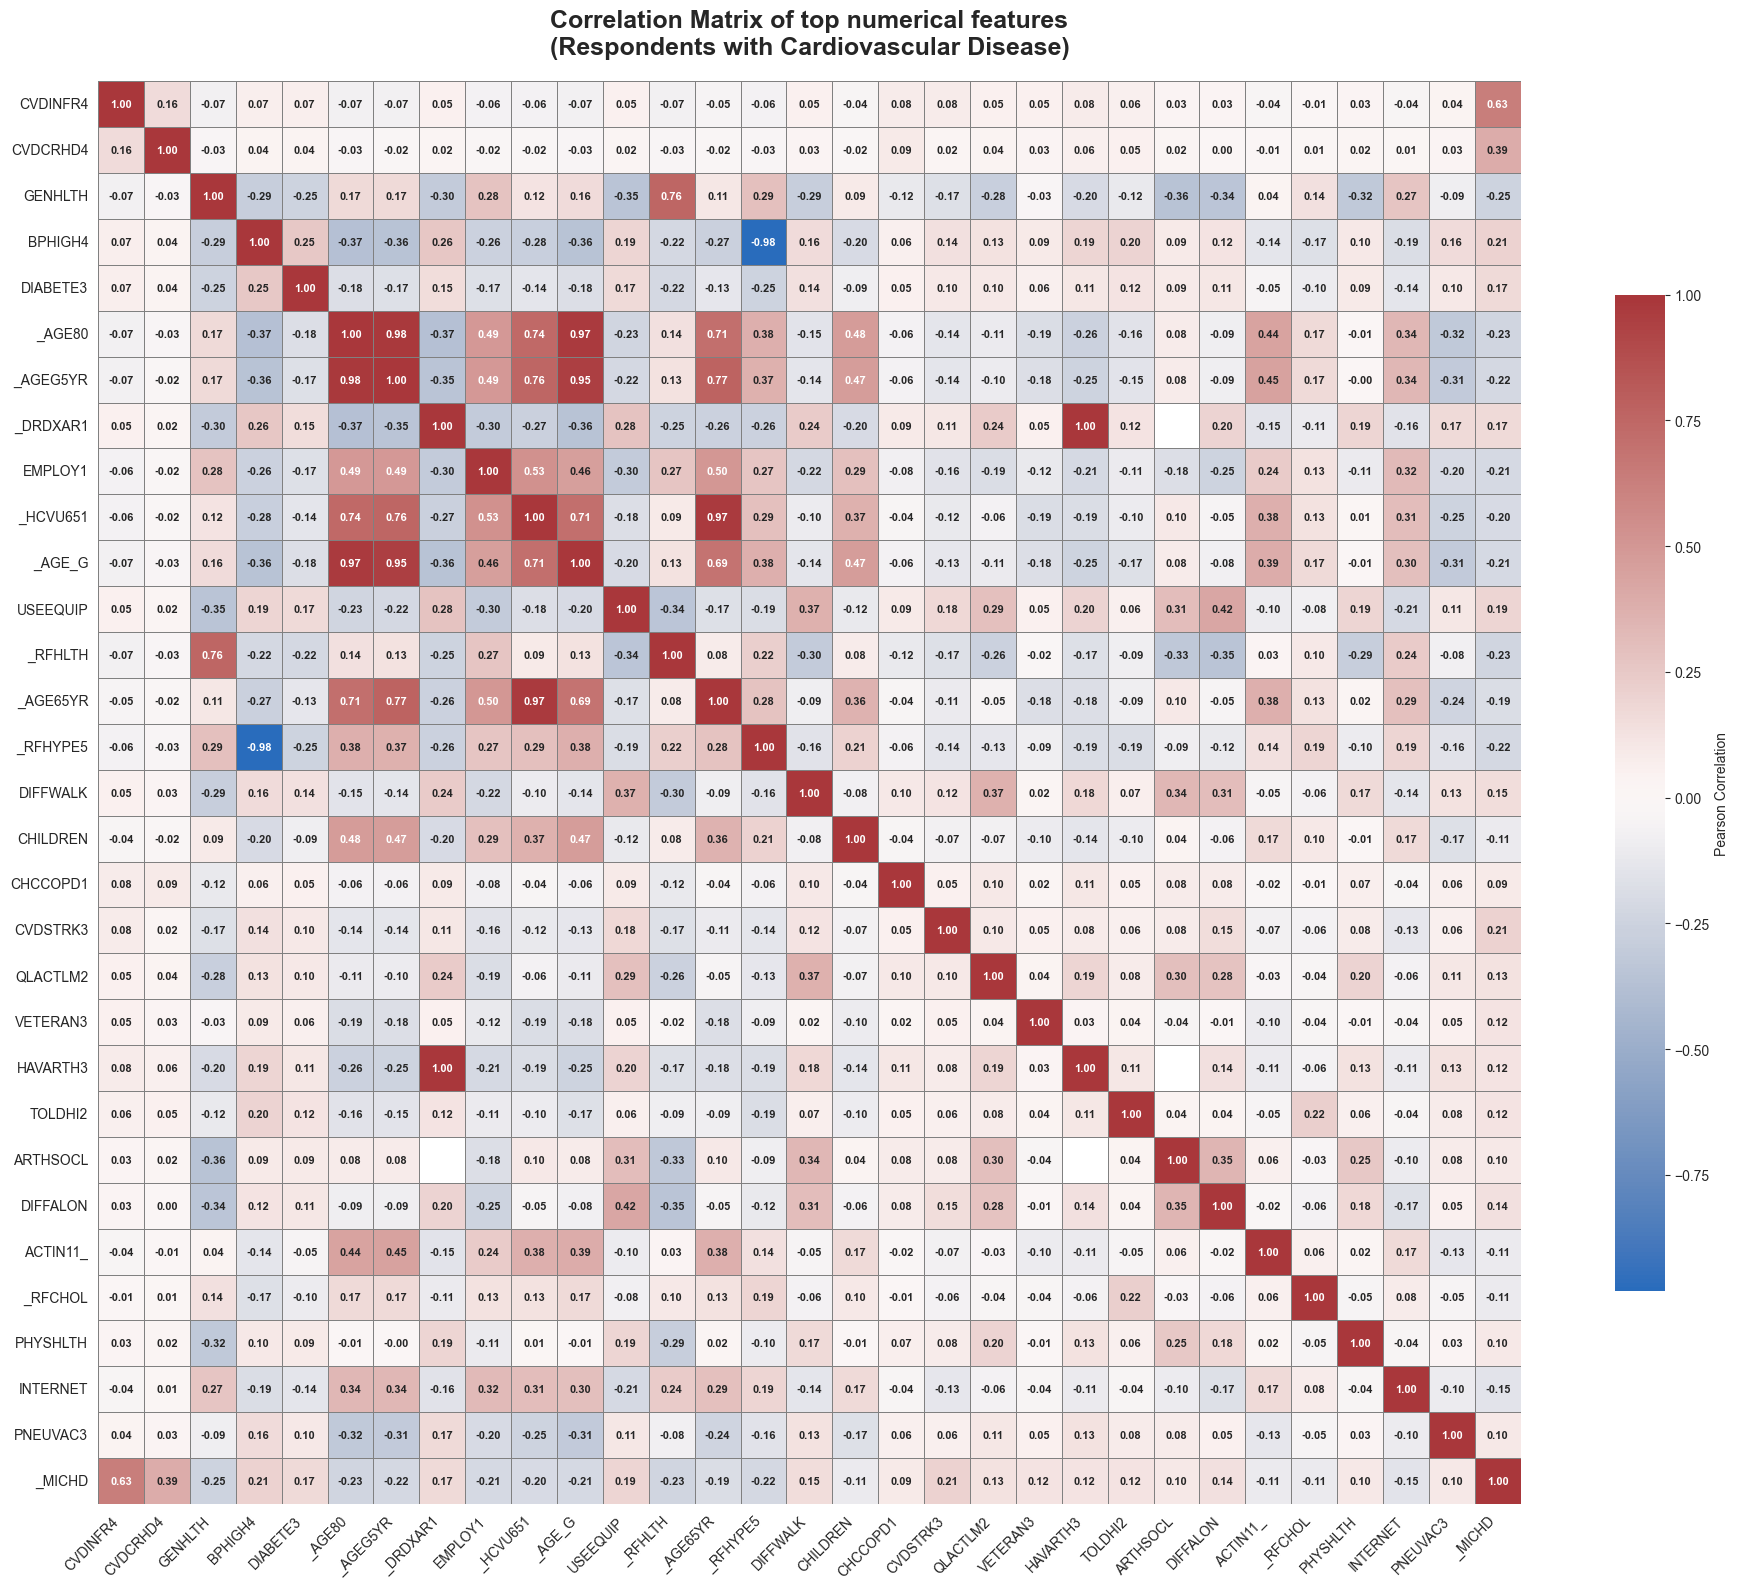

In [ ]:
plt.figure(figsize=(20, 16))  

num_contain_target = top_num + [target]
corr_matrix = df[num_contain_target].corr().round(2)

sns.heatmap(
    corr_matrix,
    annot=True,                  
    fmt='.2f',                    
    cmap='vlag',                   
    center=0,                      
    square=True,
    linewidths=0.5,               
    linecolor='gray',              
    cbar_kws={"shrink": .7, "label": "Pearson Correlation"}, 
    annot_kws={"size": 8, "weight": "bold"},  
)

plt.title('Correlation Matrix of top numerical features\n(Respondents with Cardiovascular Disease)', 
          fontsize=18, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

Severe Multicollinearity Risks (Redundant Variables)

Highly redundant features will destabilize any regression model if not addressed:

| Variable Group       | Examples                              | Correlation | Issue & Recommendation                          |
|----------------------|---------------------------------------|-------------|--------------------------------------------------|
| Age encodings   | `_AGE80`, `_AGEG5YR`, `_AGE65YR`, `_AGE_G` | ≥ 0.97      | Near-perfect overlap (different age cuts/groupings) <br>→ Keep only one (prefer `_AGEG5YR` for granularity) |
| Hypertension     | `BPHIGH4` ↔ `_RFHYP5`                 | –0.98   | Opposite coding of the same concept <br>→ **Retain only one** (e.g., `BPHIGH4`) |

> **Action**: Drop all but one representation per concept to eliminate extreme multicollinearity.